In [2]:
from bitcoinrpc.authproxy import AuthServiceProxy, JSONRPCException
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf


In [2]:
rpc_connection = AuthServiceProxy("http://%s:%s@127.0.0.1:8332"%("moises", "moises123"),timeout=100000)
#num_blocks = rpc_connection.getblockcount()
#num_blocks

In [4]:
# Pega os primeiros dados da blockchain do bitcoin e envia para uma base de dados sql
# Preciso rodar esses códigos novamente para concertar a falta de valores multiplos de 1000

chunk_size = 1000
#chunks = int(num_blocks/chunk_size)
#chunks

def initial_load():
    with sqlite3.connect('bitcoin_blockchain.db') as conn:
        for c in range(0,chunks+1):
            block_stats = [rpc_connection.getblockstats(i) for i in range(c*chunk_size+1, (c+1)*chunk_size)+1]
            df = pd.DataFrame(block_stats)
            df['feerate_percentiles'] = df['feerate_percentiles'].astype(str)
            df.to_sql('blockchain', conn, if_exists='append') 
        print(f'finished {(c+1)*chunk_size} record')

def update_chain(start_block):
    num_blocks = rpc_connection.getblockcount()
    block_stas = [rpc_connection.getblockstats(i) for i in range(start_block, num_blocks)]
    df = pd.DataFrame(block_stas)
    df["feerate_percentiles"] = df["feerate_percentiles"].astype(str)
    df.to_sql("blockchain",conn, if_exists='append')

In [5]:
#initial_load() Só precisa fazer uma vez
#update_chain(801000) Atualizar depois 

In [3]:
conn = sqlite3.connect("bitcoin_blockchain.db")
df = pd.read_sql("select * from blockchain", conn)

In [9]:
#Util apenas para encontrar o erro do pq o index está diferente do hight do bloco.
"""for index, sub in enumerate(df["subsidy"]):
    if index%1000 == 0:
        user_input = input("Continuar? (s/n): ")
        if user_input== "n":
            break
    print(index, sub) 
"""

'for index, sub in enumerate(df["subsidy"]):\n    if index%1000 == 0:\n        user_input = input("Continuar? (s/n): ")\n        if user_input== "n":\n            break\n    print(index, sub) \n'

In [10]:
# Convertendo os dados de hora de unix time para GMT
df["GMT"] = pd.to_datetime(df["time"], unit="s")

# Criação da coluna de subsidio em btc (transformando satoshi em btc)
df["reward"] = df["subsidy"]/10**(8)

# Criação coluna de soma cumulativa da quantidade de btc minerados
df["total_supply"] = df["reward"].cumsum()

# Criação da coluna do ano
df["year"] = df["GMT"].dt.year

0   2009-01-09 02:54:25
1   2009-01-09 02:55:44
2   2009-01-09 03:02:53
3   2009-01-09 03:16:28
4   2009-01-09 03:23:48
Name: GMT, dtype: datetime64[ns]

In [15]:
# Nomes das colunas do dataframe
df.columns

Index(['index', 'avgfee', 'avgfeerate', 'avgtxsize', 'blockhash',
       'feerate_percentiles', 'height', 'ins', 'maxfee', 'maxfeerate',
       'maxtxsize', 'medianfee', 'mediantime', 'mediantxsize', 'minfee',
       'minfeerate', 'mintxsize', 'outs', 'subsidy', 'swtotal_size',
       'swtotal_weight', 'swtxs', 'time', 'total_out', 'total_size',
       'total_weight', 'totalfee', 'txs', 'utxo_increase', 'utxo_size_inc',
       'utxo_increase_actual', 'utxo_size_inc_actual', 'GMT', 'reward',
       'total_supply'],
      dtype='object')

In [19]:
# Criação do dicionário de recompensas por ano
reward = {i: df.loc[df.year == i, "reward"].sum() for i in df.year.unique()}

reward

{2009: 1622850.0,
 2010: 3392600.0,
 2011: 2978350.0,
 2012: 2609650.0,
 2013: 1584250.0,
 2014: 1470150.0,
 2015: 1356650.0,
 2016: 1044825.0,
 2017: 698412.5,
 2018: 680537.5,
 2019: 677225.0,
 2020: 452868.75,
 2021: 328956.25,
 2022: 332093.75,
 2023: 194887.5}

In [20]:
year = []
subsidy = []
for i in range(2009,2023):
    year.append(i)
    subsidy.append(reward[i])


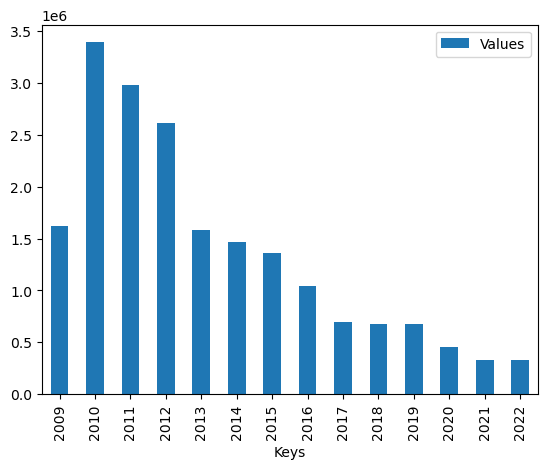

In [21]:


# Example keys and values

# Create a dictionary from keys and values
data_dict = {'Keys': year, 'Values': subsidy}

# Create a DataFrame from the dictionary
data = pd.DataFrame(data_dict)

# Plot the DataFrame
data.plot(x = "Keys", y = "Values", kind = "bar")
plt.show()


In [22]:
# Criação da coluna Annual Flow
for i in df.year.unique():
    df.loc[df["year"]==i, "annual_flow"] = reward[i] 

# Criação da coluna Stock to Flow Ratio
df["sf_ratio"]= df["total_supply"]/df["annual_flow"]

# Criação da coluna de data amigavel (string)
df["GMT_date"] =df["GMT"].dt.date 

# Agrupamento dos dados por dia para serem comparados com os dados de preço
df_daily = df.groupby("GMT_date", as_index = False).agg({"GMT_date":"first", "sf_ratio":"max", "total_supply":"max"})

In [ ]:
# Convertendo datas para datetime pegando até o ultimo dia do mês
dates = []
for y in df['year'].unique():
    for m in range(1,13):
        dates.append(dt.datetime(y,m,calendar.monthrange(y,m)[1]).date())

final_df = df.loc[df['GMT_date'].isin(dates)]

# Historical Bitcoin Price and Market Cap 

In [ ]:
# Pega os preços do BTC do yahoo finance
get = yf.Ticker("BTC-USD")

btc_data = yf.download("BTC-USD", start="2009-01-01", end="2022-12-31")

# Concerta o cabeçalho
btc_data = btc_data.reset_index()

[*********************100%***********************]  1 of 1 completed


In [ ]:
btc_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...,...
3022,2022-12-26,16842.250000,16920.123047,16812.369141,16919.804688,16919.804688,11886957804
3023,2022-12-27,16919.291016,16959.845703,16642.072266,16717.173828,16717.173828,15748580239
3024,2022-12-28,16716.400391,16768.169922,16497.556641,16552.572266,16552.572266,17005713920
3025,2022-12-29,16552.322266,16651.755859,16508.683594,16642.341797,16642.341797,14472237479


In [ ]:
btc_data["Market_cap"] = btc_data["Close"] * btc_data["Volume"]
btc_data["Date"] = btc_data["Date"].dt.date
btc_data

,Date,Open,High,Low,Close,Adj Close,Volume,Market_cap
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800,9.629991e+09
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200,1.463605e+10
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700,1.497055e+10
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600,1.507367e+10
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100,1.060070e+10
...,...,...,...,...,...,...,...,...
3022,2022-12-26,16842.250000,16920.123047,16812.369141,16919.804688,16919.804688,11886957804,2.011250e+14
3023,2022-12-27,16919.291016,16959.845703,16642.072266,16717.173828,16717.173828,15748580239,2.632718e+14
3024,2022-12-28,16716.400391,16768.169922,16497.556641,16552.572266,16552.572266,17005713920,2.814883e+14
3025,2022-12-29,16552.322266,16651.755859,16508.683594,16642.341797,16642.341797,14472237479,2.408519e+14


In [ ]:
# fiding the index of the max value in btc_data
max_index = btc_data['Market_cap'].idxmax()

#fiding the previous day's index
previous_index = max_index - 1

# finding the date of the max
max_date = btc_data.loc[max_index, 'Date']

# finding the value of  market cap of the previous day
previous_index_maket_cap = btc_data.loc[previous_index, 'Market_cap']

#substitue the value of the max market cap in the btc_data dataframe
btc_data.loc[max_index, 'Market_cap'] = previous_index_maket_cap



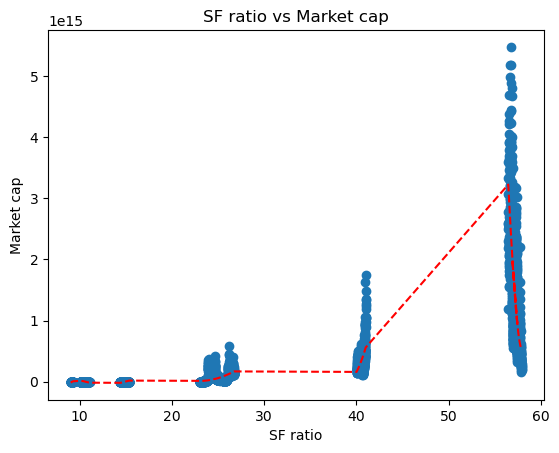

In [ ]:
#convert the date 2014-9-17 to datetime.date format
data_inicial = dt.date(2014, 9, 17)
data_final = dt.date(2022, 12, 30)

#get the df_daily just after the date 2014-09-17
df_daily = df_daily[df_daily["GMT_date"] > data_inicial] 
df_daily = df_daily[df_daily["GMT_date"] < data_final]
btc_data = btc_data[btc_data["Date"] > data_inicial]
btc_data = btc_data[btc_data["Date"] < data_final]

X = df_daily["sf_ratio"]
y = btc_data["Market_cap"]
plt.scatter(X, y)
plt.xlabel("SF ratio")
plt.ylabel("Market cap")
plt.title("SF ratio vs Market cap")

#add the trendline
z = np.polyfit(X, y, 10)
p = np.poly1d(z)
plt.plot(X,p(X),"r--")

plt.show()

/tmp/ipykernel_22778/2534676268.py:10: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(X, y, 50)


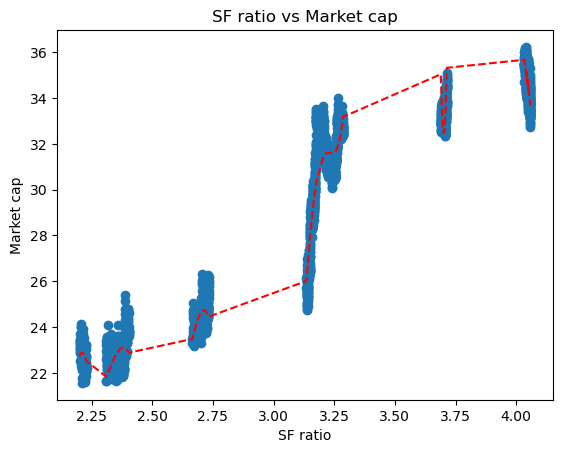

In [ ]:
# Um padrão de preço do Bitcoin começa a se formar com log  nas variáves de SF ratio e Market cap
X = np.log(df_daily["sf_ratio"])
y = np.log(btc_data["Market_cap"])
plt.scatter(X, y)
plt.xlabel("SF ratio")
plt.ylabel("Market cap")
plt.title("SF ratio vs Market cap")

#add the trendline
z = np.polyfit(X, y, 50)
p = np.poly1d(z)
plt.plot(X,p(X),"r--")

plt.show()

In [ ]:
#assign input and output variables to X and y
X = X.values.reshape(-1,1)
y = y

#transform the variables using log function
y_log = np.log(y)
x_log = np.log(X)

linreg = LinearRegression().fit(x_log ,y_log)

In [ ]:
print(f"R^2 : {linreg.score(x_log, y_log):.1%}")

# Score (R^2) sugere que o modelo explica 87% da variância dos dados



R^2 : 89.7%


In [ ]:
def btc_fit_plot(x_, y_):
    
    linreg = LinearRegression().fit(x_,y_)
    y_pred = linreg.predict(x_)
    fig,ax = plt.subplots()
    plt.scatter(x_,y_, marker = 'o')
    plt.plot(x_, y_pred, color = 'red')
    ax.set_title('BTC market cap vs S_F ratio')
    ax.set_xlabel('S_F ratio')
    ax.set_ylabel('BTC Market Cap')
    [ax.spines[loc].set_visible(False) for loc in ['top', 'right']]
    ax.tick_params(left= False,bottom= False)
    
    
    
    explained_variance=metrics.explained_variance_score(y_, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_, y_pred) 
    mse=metrics.mean_squared_error(y_, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_, y_pred)
    r2=metrics.r2_score(y_, y_pred)
    
    f_stat, p_f_stats = f_regression(x_, y_)

    print(f'Model coefficient: {linreg.coef_}')
    print(f'Model intercept: {linreg.intercept_}')
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print(f'F-stats: {f_stat}') 
    print(f'prob(F-stats): {p_f_stats}')
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    
    return linreg


Model coefficient: [0.8088994]
Model intercept: 2.4438688690562604
explained_variance:  0.8969
mean_squared_log_error:  0.0001
r2:  0.8969
F-stats: [26285.96192513]
prob(F-stats): [0.]
MAE:  0.0414
MSE:  0.0027
RMSE:  0.0515


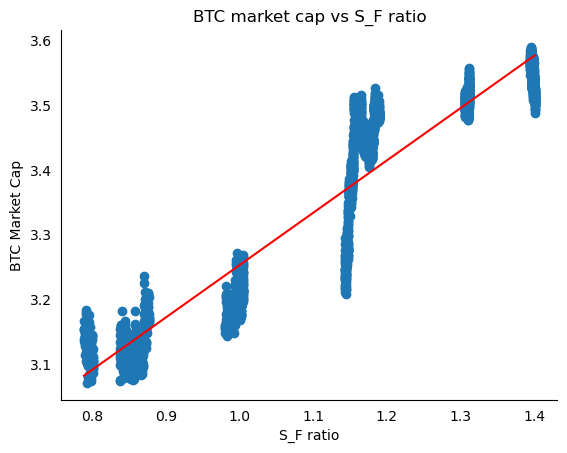

In [ ]:
linreg = btc_fit_plot(x_log, y_log)

### Métricas adicionais

In [ ]:
import statsmodels.api as sm
x_log_1 = sm.add_constant(x_log)
model=sm.OLS(y_log,x_log_1)

results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Market_cap   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                 2.629e+04
Date:                Mon, 14 Aug 2023   Prob (F-statistic):               0.00
Time:                        16:48:29   Log-Likelihood:                 4677.6
No. Observations:                3025   AIC:                            -9351.
Df Residuals:                    3023   BIC:                            -9339.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4439      0.006    413.683      0.000       2.432       2.455
x1             0.8089      0.005    162.129      0.000       0.799       0.819
==============================================================================
Omnibus:                       14.819   Durbin-Watson:                   0.053
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               13.249
Skew:                           0.114   Prob(JB):                      0.00133
Kurtosis:                       2.769   Cond. No.                         12.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""